Loading and synchronizing data...
Aligning SLAM trajectory to GNSS trajectory...
Recalculating error with aligned data...

Error Statistics (after alignment):
count    2093.000000
mean       16.672018
std        13.564344
min         1.574235
25%        10.167168
50%        12.410700
75%        13.980435
max        61.313609
Name: aligned_error, dtype: float64

Generating plots...

Plots 'trajectory_alignment.png' and 'final_error_plot.png' have been saved.


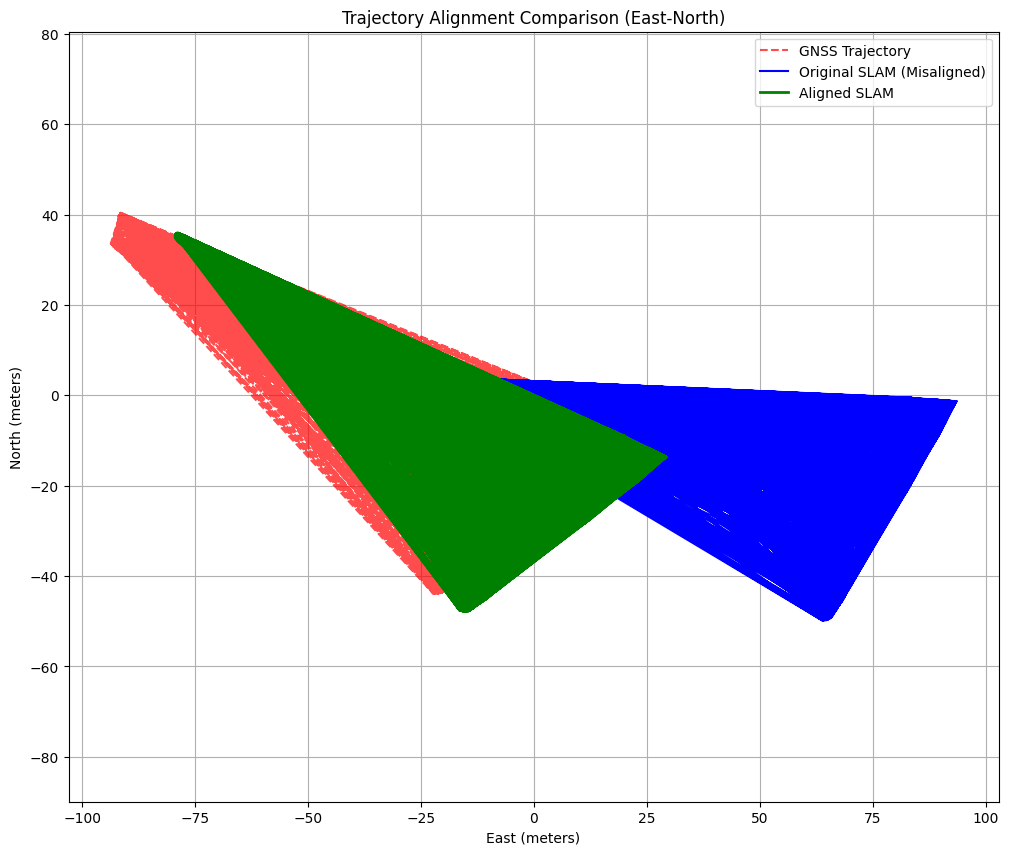

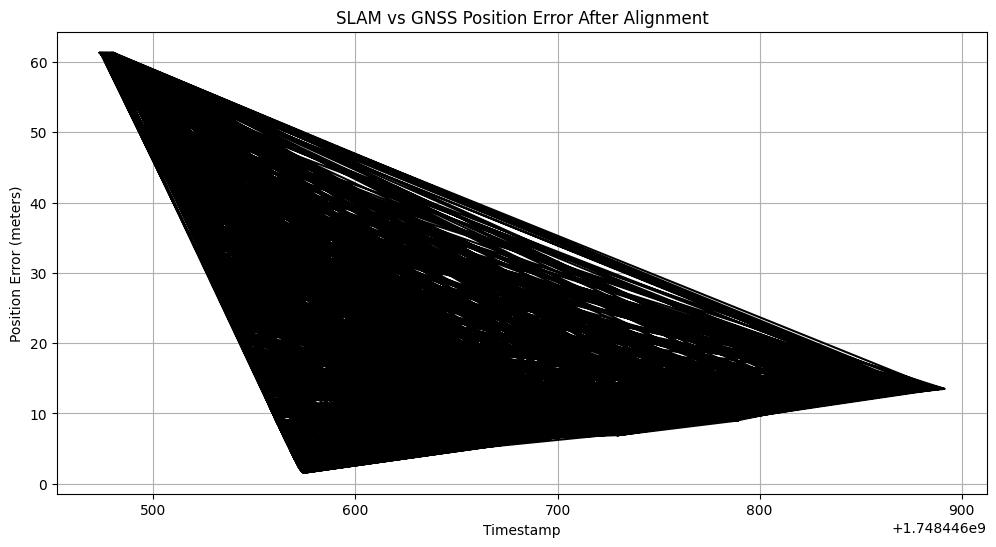

In [5]:
import pandas as pd
from scipy.spatial import KDTree
import numpy as np
import matplotlib.pyplot as plt
import pymap3d as pm


def umeyama_align(model, data):
    """
    Computes the optimal rigid transformation (rotation, translation)
    to align the 'model' point set to the 'data' point set.
    """
    model_centroid = np.mean(model, axis=0)
    data_centroid = np.mean(data, axis=0)

    model_centered = model - model_centroid
    data_centered = data - data_centroid

    # Covariance matrix (note: data @ model order)
    H = data_centered.T @ model_centered

    # SVD
    U, S, Vt = np.linalg.svd(H)
    R = U @ Vt

    # Fix reflection
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = U @ Vt

    # Translation
    t = data_centroid - R @ model_centroid
    return R, t


# --- Part 1: Load and Synchronize Data ---
print("Loading and synchronizing data...")
slam_df = pd.read_csv('SLAM_poses_v2.csv')
gnss_df = pd.read_csv('GNSS_data_v2.csv')

# Remove bad GNSS rows
gnss_df_clean = gnss_df.dropna(subset=['latitude', 'longitude', 'altitude']).copy()

# Match timestamps (nearest neighbor)
tree = KDTree(gnss_df_clean['#timestamp'].values.reshape(-1, 1))
distances, indices = tree.query(slam_df['#timestamp'].values.reshape(-1, 1))
matched_gnss_df = gnss_df_clean.iloc[indices].reset_index(drop=True)

merged_df = pd.concat([
    slam_df.rename(columns={'#timestamp': 'slam_timestamp'}),
    matched_gnss_df.rename(columns={'#timestamp': 'gnss_timestamp'})
], axis=1)

# --- Part 2: Convert GNSS to ENU ---
lat0, lon0, alt0 = merged_df['latitude'].iloc[0], merged_df['longitude'].iloc[0], merged_df['altitude'].iloc[0]
gnss_x, gnss_y, gnss_z = pm.geodetic2enu(
    merged_df['latitude'].values,
    merged_df['longitude'].values,
    merged_df['altitude'].values,
    lat0, lon0, alt0, deg=True
)


merged_df['gnss_x'] = gnss_x
merged_df['gnss_y'] = gnss_y
merged_df['gnss_z'] = gnss_z

# --- Part 3: Align SLAM to GNSS (3D) ---
print("Aligning SLAM trajectory to GNSS trajectory...")
slam_points = merged_df[['x', 'y', 'z']].values
gnss_points = merged_df[['gnss_x', 'gnss_y', 'gnss_z']].values

# Run Umeyama
R, t = umeyama_align(slam_points, gnss_points)

# Apply transformation
slam_points_aligned = (R @ slam_points.T).T + t

merged_df['slam_x_aligned'] = slam_points_aligned[:, 0]
merged_df['slam_y_aligned'] = slam_points_aligned[:, 1]
merged_df['slam_z_aligned'] = slam_points_aligned[:, 2]

# --- Part 4: Error Statistics ---
print("Recalculating error with aligned data...")
merged_df['aligned_error'] = np.sqrt(
    (merged_df['slam_x_aligned'] - merged_df['gnss_x'])**2 +
    (merged_df['slam_y_aligned'] - merged_df['gnss_y'])**2 + 
    (merged_df['slam_z_aligned'] - merged_df['gnss_z'])**2
)

print("\nError Statistics (after alignment):")
print(merged_df['aligned_error'].describe())

# --- Part 5: Generate Final Plots ---
print("\nGenerating plots...")

# Plot 1: 2D trajectory comparison (East-North plane)
plt.figure(figsize=(12, 10))
plt.plot(merged_df['gnss_x'], merged_df['gnss_y'], 'r--', label='GNSS Trajectory', alpha=0.7)
plt.plot(merged_df['x'], merged_df['y'], 'b-', label='Original SLAM (Misaligned)')
plt.plot(merged_df['slam_x_aligned'], merged_df['slam_y_aligned'], 'g-', linewidth=2, label='Aligned SLAM')
plt.title('Trajectory Alignment Comparison (East-North)')
plt.xlabel('East (meters)')
plt.ylabel('North (meters)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.savefig('trajectory_alignment.png')

# Plot 2: Error over time
plt.figure(figsize=(12, 6))
plt.plot(merged_df['slam_timestamp'], merged_df['aligned_error'], 'k-')
plt.title('SLAM vs GNSS Position Error After Alignment')
plt.xlabel('Timestamp')
plt.ylabel('Position Error (meters)')
plt.grid(True)
plt.savefig('final_error_plot.png')

print("\nPlots 'trajectory_alignment.png' and 'final_error_plot.png' have been saved.")
plt.show()


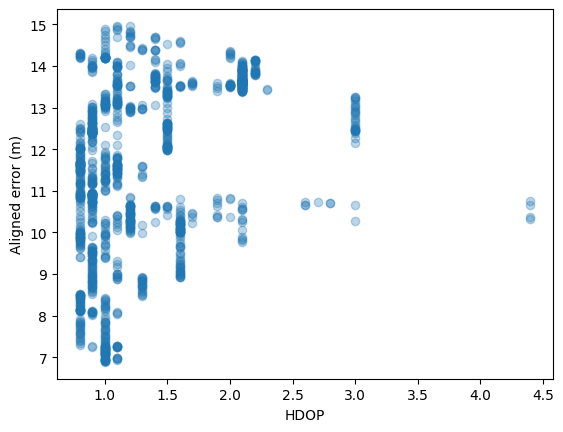

In [6]:
import matplotlib.pyplot as plt
plt.scatter(merged_df['hdop'], merged_df['aligned_error'], alpha=0.3)
plt.xlabel('HDOP'); plt.ylabel('Aligned error (m)')

plt.show()